In [1223]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1224]:
cd ~/workspace/theislab/mubind/notebooks/pbm

/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/notebooks/pbm


In [1225]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import seaborn as sns
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [1264]:
df = mb.bindome.datasets.PBM.pbm_paralogs()

In [1265]:
n_sample = 2000

In [1525]:
df

,Column,Row,Name,ID,Sequence,Cy3,Cy3Flags,Alexa488,Alexa488Flags,Cy3Exp,Obs/Exp,Alexa488Norm,Alexa488Median,Alexa488Adjusted,filename,description
0,1,1,GE_BrightCorner,GE_BrightCorner,NaN,1.0,NaN,13047,NaN,1.0,1.0,13047.0,2755.0,15438.555354,GSM2575567_Runx1_10nM_alldata.txt.gz,Runx1 at 10 nM concentration
1,2,1,GE_BrightCorner,GE_BrightCorner,NaN,1.0,NaN,12487,NaN,1.0,1.0,12487.0,2581.0,15772.034095,GSM2575567_Runx1_10nM_alldata.txt.gz,Runx1 at 10 nM concentration
2,3,1,DarkCorner,DarkCorner,NaN,1.0,NaN,475,NaN,1.0,1.0,475.0,2528.0,612.539557,GSM2575567_Runx1_10nM_alldata.txt.gz,Runx1 at 10 nM concentration
3,4,1,DarkCorner,DarkCorner,NaN,1.0,NaN,542,NaN,1.0,1.0,542.0,2536.0,696.735016,GSM2575567_Runx1_10nM_alldata.txt.gz,Runx1 at 10 nM concentration
4,5,1,DarkCorner,DarkCorner,NaN,1.0,NaN,462,NaN,1.0,1.0,462.0,2581.0,583.541263,GSM2575567_Runx1_10nM_alldata.txt.gz,Runx1 at 10 nM concentration
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45215,262,170,DarkCorner,DarkCorner,NaN,1.0,NaN,1150,NaN,NaN,NaN,NaN,NaN,NaN,GSM3293890_Runx2_uPBM_rawdata.txt.gz,Runx2 at 200 nM concentration
45216,263,170,DarkCorner,DarkCorner,NaN,1.0,NaN,1097,NaN,NaN,NaN,NaN,NaN,NaN,GSM3293890_Runx2_uPBM_rawdata.txt.gz,Runx2 at 200 nM concentration
45217,264,170,DarkCorner,DarkCorner,NaN,1.0,NaN,1117,NaN,NaN,NaN,NaN,NaN,NaN,GSM3293890_Runx2_uPBM_rawdata.txt.gz,Runx2 at 200 nM concentration
45218,265,170,DarkCorner,DarkCorner,NaN,1.0,NaN,1132,NaN,NaN,NaN,NaN,NaN,NaN,GSM3293890_Runx2_uPBM_rawdata.txt.gz,Runx2 at 200 nM concentration


In [1526]:
keys = {'Runx2 at 10 nM concentration'}
df2 = df[df['description'].isin(keys)]


In [1527]:
df2.columns

Index(['Column', 'Row', 'Name', 'ID', 'Sequence', 'Cy3', 'Cy3Flags',
       'Alexa488', 'Alexa488Flags', 'Cy3Exp', 'Obs/Exp', 'Alexa488Norm',
       'Alexa488Median', 'Alexa488Adjusted', 'filename', 'description'],
      dtype='object')

In [1528]:
df2 = df2[~pd.isnull(df2['Name']) & df2['Name'].str.contains('Bound')].groupby('Sequence').median()

In [1441]:
# df2['Name'].value_counts()

In [1529]:
df2.index.value_counts()

AAAAAAAAAAAAAAAAACCCACACAGTCAGCAAGGGGTCTTGATTCGCTTGACGCTGCTG    1
GGCTGAATGGAGGATTGTGGCTGCGTCTGATCCTTAGTCTTGATTCGCTTGACGCTGCTG    1
GGCTGTGTGTGCCTGACCGCTAACTCTCTACTCTGTGTCTTGATTCGCTTGACGCTGCTG    1
GGCTGTGTTTCTGTTTGTGGGCTAGTAATTTAGGCTGTCTTGATTCGCTTGACGCTGCTG    1
GGCTGTTAGTTTTTTTGTGGTTGCTATCTCACTGTAGTCTTGATTCGCTTGACGCTGCTG    1
                                                               ..
CCAGGATGGAGCCAAACCACGACGTGGAGGGCCTGCGTCTTGATTCGCTTGACGCTGCTG    1
CCAGGATGGAGTGCTTCTGTGGGGAGGAAGATAGGCGTCTTGATTCGCTTGACGCTGCTG    1
CCAGGATGTTCATGCTGTGGTTACTACCTGCCTGTGGTCTTGATTCGCTTGACGCTGCTG    1
CCAGGCAAAACAGGAACCACAAACCCCAGCTTCCTCGTCTTGATTCGCTTGACGCTGCTG    1
TTTTTTTTTTTTTTTTTTGCGGAGGAAACGAGGTTGGTCTTGATTCGCTTGACGCTGCTG    1
Name: Sequence, Length: 45152, dtype: int64

In [1530]:
# data = df[df['description'].isin({'Runx2 at 50 nM concentration'})] #  'Runx1 at 50 nM concentration'})] # , 'Runx1 at 10 nM concentration', 'Runx2 at 10 nM concentration'})]
# data = data[~data['Sequence'].isna()]# [['Sequence', 'Alexa488Adjusted']]
data = df2.copy()
data = data[['Alexa488Adjusted']]
data.columns = [0]

data = data.sample(n=n_sample) if n_sample is not None else data

# data[1] = data[0]
# data[0] = np.median(data[1])
# data[1] = np.log(data[1])

data[0] = np.log(data[0])

data

,0
Sequence,
TCACACAGTTGTGCAACCACCACTACCGCCATCCATGTCTTGATTCGCTTGACGCTGCTG,7.510427
GCTGTTGCGACACCCACTGCGGGGAATGAGGAAGCGGTCTTGATTCGCTTGACGCTGCTG,7.148856
CGTCTCAGCAAATCAACCACAGAGAGTTTATGGCTAGTCTTGATTCGCTTGACGCTGCTG,10.181751
TCAGCAGGACCTTGCTCTGTGGGACTCTGGCCAGGTGTCTTGATTCGCTTGACGCTGCTG,6.501454
GGAAAGGAGAGAGTCTGTGGTATCTGCCCCAAGACCGTCTTGATTCGCTTGACGCTGCTG,9.062418
...,...
GGTCTGGTGGAAAGAACCACCACTTACTAGCTACATGTCTTGATTCGCTTGACGCTGCTG,7.592499
TCTGAAAATGCAAGATGCGGTATGTTGGATCAAGTGGTCTTGATTCGCTTGACGCTGCTG,8.683197
CTACTTCCGGACTGTACCGCATGTAATGAAGTTATAGTCTTGATTCGCTTGACGCTGCTG,8.324066


In [1531]:
data['batch'] = 'Runx2'

In [1532]:
data.shape

(2000, 2)

In [1533]:
data

,0,batch
Sequence,,
TCACACAGTTGTGCAACCACCACTACCGCCATCCATGTCTTGATTCGCTTGACGCTGCTG,7.510427,Runx2
GCTGTTGCGACACCCACTGCGGGGAATGAGGAAGCGGTCTTGATTCGCTTGACGCTGCTG,7.148856,Runx2
CGTCTCAGCAAATCAACCACAGAGAGTTTATGGCTAGTCTTGATTCGCTTGACGCTGCTG,10.181751,Runx2
TCAGCAGGACCTTGCTCTGTGGGACTCTGGCCAGGTGTCTTGATTCGCTTGACGCTGCTG,6.501454,Runx2
GGAAAGGAGAGAGTCTGTGGTATCTGCCCCAAGACCGTCTTGATTCGCTTGACGCTGCTG,9.062418,Runx2
...,...,...
GGTCTGGTGGAAAGAACCACCACTTACTAGCTACATGTCTTGATTCGCTTGACGCTGCTG,7.592499,Runx2
TCTGAAAATGCAAGATGCGGTATGTTGGATCAAGTGGTCTTGATTCGCTTGACGCTGCTG,8.683197,Runx2
CTACTTCCGGACTGTACCGCATGTAATGAAGTTATAGTCTTGATTCGCTTGACGCTGCTG,8.324066,Runx2


In [1534]:
data = data[~data[0].isna()]
data[0] = (data[0] - data[0].mean()) # / data[0].std()
# data[1] = data[0]


(array([0]), [Text(0, 0, 'Runx2')])

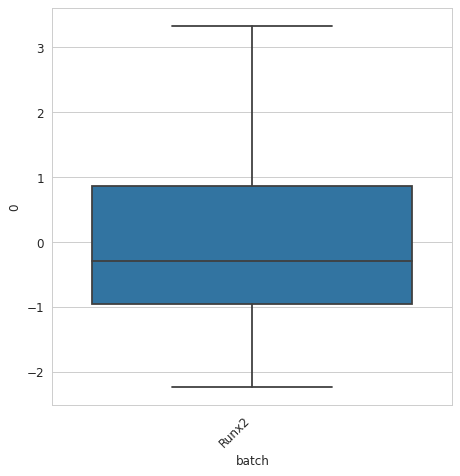

In [1535]:
sns.boxplot(data=data, x='batch', y=0)
plt.xticks(rotation=45, ha='right')

<AxesSubplot: ylabel='Density'>

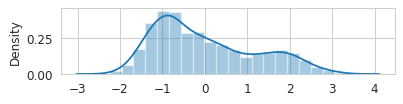

In [1551]:
sns.distplot(np.array(data[0]))

In [1537]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 1

In [1538]:
# data = data.set_index('seq')
data.index.name = 'seq'
# remove flanks (constant)


In [1539]:
data.index = data.index.str[:-24]

In [1540]:
import itertools
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()


batches = set(data['batch'])
thr = 0.75
rel = np.zeros((len(batches), len(batches)))
for ai, bi in itertools.combinations(enumerate(batches), r=2):
    a, b = ai[1].split(' ')[0], bi[1].split(' ')[0]
    ratio_similar = similar(a, b)
    # print(a, b, ratio_similar)
    if ratio_similar >= thr:
        print(ai, bi, a, b, ratio_similar)
        rel[ai[0], bi[0]] = 1
        rel[bi[0], ai[0]] = 1
    # print(ai, bi)
rel

array([[0.]])

In [1541]:
set(data['batch'])

{'Runx2'}

In [1542]:
df2 = []
for b, grp in data.groupby('batch'):
    grp = grp[~grp.index.duplicated(keep='first')]
    df2.append(grp)
data = pd.concat(df2)


In [1550]:
pat = 'GCGGTT'
data['has_pat'] = data.index.str.contains(pat)
data.groupby('has_pat').mean()

,0
has_pat,
False,-0.014319
True,0.526008


In [ ]:
sns.dis

In [1499]:
print('loading object (# entries)', data.shape[0])
dataset = mb.datasets.SelexDataset(data, n_rounds=1, enr_series=False, labels=[0])
# dataset = mb.datasets.PBMDataset(data)
train = tdata.DataLoader(dataset=dataset, batch_size=512, shuffle=True)

loading object (# entries) 2000


# Simple model with MSE Loss and association between filters on each experiment

In [1500]:
# define if batches should have associated kernels


In [1501]:
n_tfs = rel.shape[0]

In [1517]:
# mb.models.Multibind.make_model()
# model = mb.models.Multibind("pbm", n_kernels=2, criterion = mb.tl.MSELoss(), use_dinuc=False,
#                             kernels=[0, 14], n_rounds=1,
#                             n_batches=1).to(device)

criterion = mb.tl.MSELoss()
model = mb.models.Multibind.make_model(train, 4, criterion, kernels=[0] + [20] * n_tfs, n_rounds=1, kernel_sim=rel).cuda()
                                       # use_dinuc=True, dinuc_mode='local')
model.datatype = 'pbm'
model.selex_module.enr_series = False



here... 2
Using device: cuda:0


In [1518]:
# this is a relatedness matrix for matrices
model.kernel_rel

tensor([[0.]], dtype=torch.float64)

In [1519]:
# model = mb.models.Multibind(use_dinuc=False, kernels=[0, 14], n_rounds=1, n_batches=1).to(device)
# optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = topti.LBFGS(model.parameters())
# criterion = mb.tl.PoissonLoss()

In [1520]:
import warnings
warnings.filterwarnings("ignore")

In [1521]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [1522]:
# # mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=500, early_stopping=10, log_each=10, verbose=2)
# %lprun -f model.optimize_simple model.optimize_iterative(train, log_each=10, verbose=2, r2_per_epoch=False, dirichlet_regularization=True, n_epochs=[1000, 200, 200, 200],early_stopping=[10, 20, 20, 20], opt_kernel_length=[0, 0, 0, 0], opt_kernel_shift=[0, 0, 1, 1])

In [1523]:
model.optimize_kernel_rel = False
model.optimize_neg_weight = False
model.optimize_sym_weight = False


# mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=500, early_stopping=10, log_each=10, verbose=2)
print(model.optimize_kernel_rel)
model, best_loss = model.optimize_iterative(train, log_each=10, verbose=2, r2_per_epoch=True, dirichlet_regularization=True,
                                            n_epochs=[3000, 200, 200, 200],early_stopping=[10, 20, 20, 20],
                                            lr=[.45, 0.01, 0.01, 0.01], # skip_kernels={0},
                                            weight_decay=[0.5, 0.001, 0.001, 0.001], print_weights=False,
                                            opt_kernel_length=[0, 0, 0, 0], opt_kernel_shift=[0, 0, 1, 1])

False
current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
kernels mask None
optimizer:  Adam 
criterion: MSELoss 
# epochs: 3000 
early_stopping: 10
lr= 0.45, weight_decay= 0.5, dir weight= True
Epoch: 11, Loss: 21.558378, R2: -19.80,  best epoch: 9,  secs per epoch: 0.122 s,  secs epoch*1k trials: 0.061s
Epoch: 21, Loss: 17.784979, R2: -16.73,  best epoch: 19,  secs per epoch: 0.097 s,  secs epoch*1k trials: 0.048s
Epoch: 31, Loss: 16.866498, R2: -15.81,  best epoch: 29,  secs per epoch: 0.088 s,  secs epoch*1k trials: 0.044s
Epoch: 41, Loss: 15.951791, R2: -14.88,  best epoch: 39,  secs per epoch: 0.084 s,  secs epoch*1k trials: 0.042s
Epoch: 51, Loss: 14.999351, R2: -13.95,  best epoch: 49,  secs per epoch: 0.081 s,  secs epoch*1k trials: 0.041s
Epoch: 61, Loss: 14.094549, R2: -13.04,  best epoch: 59,  secs per epoch: 0.080 s,  secs e

In [1480]:
model.print_weights()

here...

mono
Parameter containing:
tensor([[[[ 0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004],
          [-0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006],
          [-0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006, -0.0006],
          [ 0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004,  0.0004]]]], device='cuda:0', requires_grad=True)

dinuc
Parameter containing:
tensor([[[[ 2.5178e-04,  3.4041e-04,  3.4040e-04,  2.5176e-04,  2.5174e-04,  2.5172e-04,  2.5172e-04,  2.5172e-04,  3.4035e-04,

(2,)


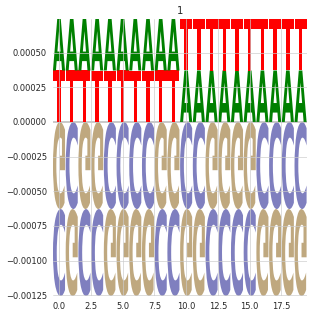

In [1481]:
rcParams['figure.figsize'] = 12, 6
rcParams['figure.dpi'] = 60
mb.pl.conv_mono(model)

In [1482]:
seqs, targets, preds = mb.tl.test_network(model, train, device)

In [1483]:
preds.shape

(2000, 1)

In [1484]:
mb.tl.scores(model, train)


{'r2_counts': -0.00224114415162302,
 'r2_foldchange': -0.00224114415162302,
 'r2_enr': -0.00224114415162302,
 'r2_fc': 0.14795819556025963,
 'pearson_foldchange': 0.38465334466277507}

In [1485]:
mb.tl.scores(model, train, by='batch')


{0: {'r2_counts': -0.002241144150924468,
  'r2_foldchange': -0.002241144150924468,
  'r2_enr': -0.002241144150924468,
  'r2_fc': 0.14795819556025963,
  'pearson_foldchange': 0.38465334466277507}}

In [1486]:
counts = mb.tl.predict(model, train)
counts

,t0,p0,batch,n_rounds,enr_pred,enr_obs,f_pred,f_obs
ATTGCTTATCTTGGGTGGTTATACACCAATACTTTGGTCTTGATTCGCTTGACGCTGCTG,-0.733989,0.047691,0,1,0.047691,-0.733989,0.047691,-0.733989
AGGGAAAGTTACCTGGCGGTCACGGAGCTACTGTCAGTCTTGATTCGCTTGACGCTGCTG,-0.173363,0.047632,0,1,0.047632,-0.173363,0.047632,-0.173363
ATTAGTGTAAATTATTGAGGTTTTATTACATACATAGTCTTGATTCGCTTGACGCTGCTG,0.743052,0.047740,0,1,0.047740,0.743052,0.047740,0.743052
TTCCTTCCTGCTGACACCACAATTCAACTTCTAGGAGTCTTGATTCGCTTGACGCTGCTG,-0.163574,0.047665,0,1,0.047665,-0.163574,0.047665,-0.163574
TACCTCATGCAAGTTTGTGGTCCAATTCATAATTCTGTCTTGATTCGCTTGACGCTGCTG,0.517933,0.047691,0,1,0.047691,0.517933,0.047691,0.517933
...,...,...,...,...,...,...,...,...
CAGCTCCTTTTGGTGTGACCACTCCCAGAGTTATTTGTCTTGATTCGCTTGACGCTGCTG,-1.127233,0.047658,0,1,0.047658,-1.127233,0.047658,-1.127233
GCTGCACCATTCTGGCCCGCAAACTTTTGAGTTGGTGTCTTGATTCGCTTGACGCTGCTG,-0.696869,0.047640,0,1,0.047640,-0.696869,0.047640,-0.696869
GGTTGAAGTTTCTTCTGTGGGCAAACTTTGTTGAAAGTCTTGATTCGCTTGACGCTGCTG,-0.530435,0.047686,0,1,0.047686,-0.530435,0.047686,-0.530435
GGCTGCTTCTCCACAACCGCGAGAAGCCCGGCTGCCGTCTTGATTCGCTTGACGCTGCTG,0.329947,0.047585,0,1,0.047585,0.329947,0.047585,0.329947


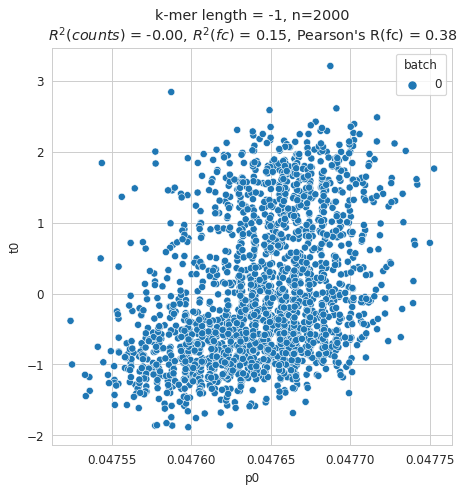

{'r2_counts': -0.002241144150880725,
 'r2_foldchange': -0.002241144150880725,
 'r2_enr': -0.002241144150880725,
 'r2_fc': 0.14795819556025966,
 'pearson_foldchange': 0.3846533446627751}

In [1487]:
rcParams['figure.figsize'] = 6, 6
rcParams['figure.dpi'] = 86
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t0', xlab='p0')
